<a href="https://colab.research.google.com/github/Gerbeev/ml_2025/blob/main/ML_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tensorflow


=== Bank Marketing Dataset ===
   V1            V2       V3         V4  V5    V6   V7   V8       V9  V10  \
0  58    management  married   tertiary  no  2143  yes   no  unknown    5   
1  44    technician   single  secondary  no    29  yes   no  unknown    5   
2  33  entrepreneur  married  secondary  no     2  yes  yes  unknown    5   
3  47   blue-collar  married    unknown  no  1506  yes   no  unknown    5   
4  33       unknown   single    unknown  no     1   no   no  unknown    5   

   V11  V12  V13  V14  V15      V16  
0  may  261    1   -1    0  unknown  
1  may  151    1   -1    0  unknown  
2  may   76    1   -1    0  unknown  
3  may   92    1   -1    0  unknown  
4  may  198    1   -1    0  unknown  


/usr/local/lib/python3.11/dist-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-62.239806961626947 > -92.021970862533564). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-60.805006086283470 > -91.780470183074996). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-63.949273849843124 > -91.841717322488222). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
/usr/local/lib/p

1413/1413 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

=== Validation Results for Isolation Forest ===
Number of valid points: 37129
Number of outliers: 8082

=== Validation Results for One-Class SVM ===
Number of valid points: 42950
Number of outliers: 2261

=== Validation Results for Local Outlier Factor ===
Number of valid points: 44576
Number of outliers: 0

=== Validation Results for Elliptic Envelope ===
Number of valid points: 40690
Number of outliers: 4521

=== Validation Results for K-means Clustering ===
Number of valid points: 7725
Number of outliers: 0

=== Validation Results for Autoencoder ===
Number of valid points: 2261
Number of outliers: 0

=== Validation Results for DBSCAN ===
Number of valid points: 39026
Number of outliers: 0

=== Validation Results for Gaussian Mixture Model ===
Number of valid points: 0
Number of outliers: 0


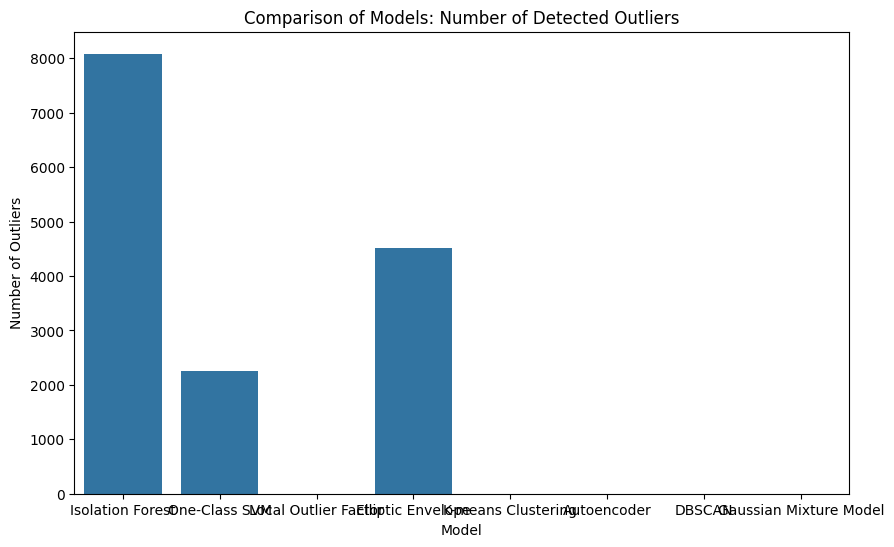

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import tensorflow as tf
#from tensorflow.python.keras.layers import Input, Dense
from tensorflow.keras.layers import Input, Dense

# Загрузка датасета Bank Marketing
data = fetch_openml(data_id=1461, as_frame=True).data
print("\n=== Bank Marketing Dataset ===")
print(data.head())

# Преобразование категориальных данных в числовые
label_encoders = {}
for column in data.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# Заполнение пропусков в числовых столбцах (на случай NaN)
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Масштабирование данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Определение моделей для валидации
models = {
    "Isolation Forest": IsolationForest(random_state=42),  # Без contamination
    "One-Class SVM": OneClassSVM(nu=0.05, kernel="rbf", gamma="scale"),  # Без contamination
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20),  # Без contamination
    "Elliptic Envelope": EllipticEnvelope(),  # Без contamination
    "K-means Clustering": KMeans(n_clusters=2, random_state=42),
    "Autoencoder": "autoencoder",  # Мы определим модель отдельно
    "DBSCAN": "dbscan",  # DBSCAN требует отнесения, будем применять отдельно
    "Gaussian Mixture Model": GaussianMixture(n_components=1, covariance_type='full')
}

# Функция для предсказания аномалий с использованием различных моделей
def validate_data_with_models(data_scaled, models):
    results = {}
    for model_name, model in models.items():
        if model_name == "Autoencoder":
            # Определение модели Autoencoder
            autoencoder = tf.keras.Sequential([
                Dense(32, activation='relu', input_dim=data_scaled.shape[1]),
                Dense(16, activation='relu'),
                Dense(8, activation='relu'),
                Dense(16, activation='relu'),
                Dense(32, activation='relu'),
                Dense(data_scaled.shape[1])
            ])
            autoencoder.compile(optimizer='adam', loss='mse')
            autoencoder.fit(data_scaled, data_scaled, epochs=50, batch_size=64, verbose=0)
            # Получаем ошибку восстановления для каждого примера
            reconstructed = autoencoder.predict(data_scaled)
            mse = np.mean(np.power(data_scaled - reconstructed, 2), axis=1)
            threshold = np.percentile(mse, 95)  # Используем 95-й процентиль для порога
            scores = (mse > threshold).astype(int)

        elif model_name == "DBSCAN":
            # DBSCAN не имеет прямого метода предсказания, используем fit_predict
            dbscan = DBSCAN(eps=0.5, min_samples=5)
            y_pred = dbscan.fit_predict(data_scaled)
            scores = (y_pred == -1).astype(int)

        else:
            # Для остальных моделей используем стандартный метод
            model.fit(data_scaled)
            if model_name == "Local Outlier Factor":
                y_pred = model.fit_predict(data_scaled)
                scores = (y_pred == 1).astype(int)
            else:
                scores = model.predict(data_scaled)

        results[model_name] = scores
    return results

# Предсказание валидности с использованием всех моделей
validation_results = validate_data_with_models(data_scaled, models)

# Отображение результатов
for model_name, scores in validation_results.items():
    print(f"\n=== Validation Results for {model_name} ===")
    print(f"Number of valid points: {np.sum(scores == 1)}")
    print(f"Number of outliers: {np.sum(scores == -1)}")

# Визуализация: сравнение моделей по количеству обнаруженных аномалий
outliers_count = {model_name: np.sum(scores == -1) for model_name, scores in validation_results.items()}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(outliers_count.keys()), y=list(outliers_count.values()))
plt.title('Comparison of Models: Number of Detected Outliers')
plt.xlabel('Model')
plt.ylabel('Number of Outliers')
plt.show()



=== Bank Marketing Dataset ===
   V1            V2       V3         V4  V5    V6   V7   V8       V9  V10  \
0  58    management  married   tertiary  no  2143  yes   no  unknown    5   
1  44    technician   single  secondary  no    29  yes   no  unknown    5   
2  33  entrepreneur  married  secondary  no     2  yes  yes  unknown    5   
3  47   blue-collar  married    unknown  no  1506  yes   no  unknown    5   
4  33       unknown   single    unknown  no     1   no   no  unknown    5   

   V11  V12  V13  V14  V15      V16  
0  may  261    1   -1    0  unknown  
1  may  151    1   -1    0  unknown  
2  may   76    1   -1    0  unknown  
3  may   92    1   -1    0  unknown  
4  may  198    1   -1    0  unknown  
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Autoencoder threshold (99-й процентиль mse): 0.3865
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

=== Results for Isolation Forest ===
Number of valid (inlier) points: 425
Number of outliers: 75

=== Results for One-Class SVM ===
Number o

<ipython-input-5-90569a474a95>:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'new_value' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_data.loc[new_data.index[0], 'V2'] = 'new_value'


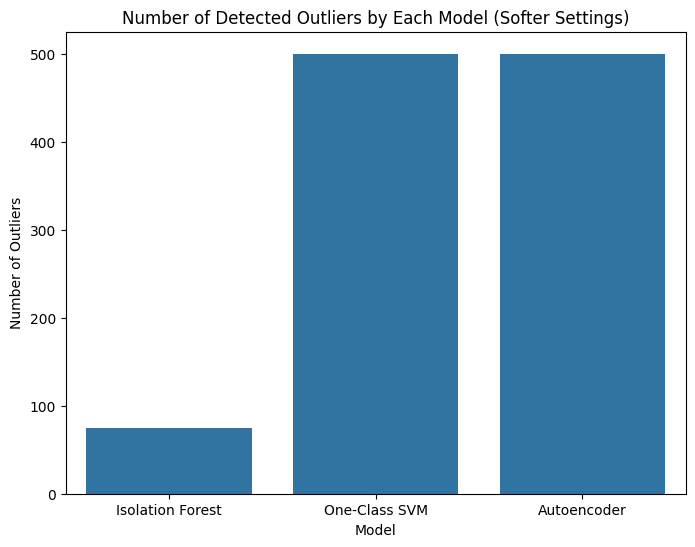

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

# ================================
# 1. Загрузка и предварительная обработка данных
# ================================

# Загружаем датасет Bank Marketing
data = fetch_openml(data_id=1461, as_frame=True).data
print("\n=== Bank Marketing Dataset ===")
print(data.head())

# Преобразование категориальных данных в числовые с помощью LabelEncoder
label_encoders = {}
for column in data.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# Заполнение пропусков в числовых столбцах (на случай наличия NaN)
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Масштабирование данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# ================================
# 2. Обучение моделей на условно корректных данных с "мягкими" настройками
# ================================

# Isolation Forest с мягкими настройками
iso_forest = IsolationForest(random_state=42, contamination=0.01)
iso_forest.fit(data_scaled)

# One-Class SVM с уменьшенным nu
one_class_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma="scale")
one_class_svm.fit(data_scaled)

# Обучение Autoencoder (нейросеть, обучаемая на реконструкцию входных данных)
input_dim = data_scaled.shape[1]
autoencoder = tf.keras.Sequential([
    tf.keras.Input(shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(input_dim)  # Выходной слой имеет размерность входных данных
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_scaled, data_scaled, epochs=50, batch_size=64, verbose=0)

# Вычисляем ошибки восстановления для обучающих данных и определяем порог по 99-му процентилю
reconstructed = autoencoder.predict(data_scaled)
mse = np.mean(np.power(data_scaled - reconstructed, 2), axis=1)
threshold = np.percentile(mse, 99)  # Порог выберем как 99-й процентиль
print(f"\nAutoencoder threshold (99-й процентиль mse): {threshold:.4f}")

# ================================
# 3. Функция для безопасного преобразования категориальных признаков
# ================================
def safe_transform_label(le, series):
    """
    Преобразует серию значений с помощью обученного LabelEncoder.
    Если значение отсутствует в le.classes_, возвращается -1.
    """
    return series.astype(str).apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# ================================
# 4. Функция для инференса на новых данных
# ================================
def validate_new_data(new_data, scaler, iso_forest, one_class_svm, autoencoder, threshold):
    """
    Проверка новых данных:
      - Применяются те же преобразования (кодирование категориальных признаков, заполнение пропусков, масштабирование)
      - Модели возвращают предсказания: 1 – inlier (корректные), -1 – outlier (аномалия)
    """
    new_data_processed = new_data.copy()

    # Обработка категориальных признаков
    for col, le in label_encoders.items():
        if col in new_data_processed.columns:
            new_data_processed[col] = safe_transform_label(le, new_data_processed[col])

    # Заполнение пропусков для числовых столбцов
    new_data_processed[numeric_columns] = new_data_processed[numeric_columns].fillna(
        data[numeric_columns].median())

    # Масштабирование
    new_data_scaled = scaler.transform(new_data_processed)

    # Предсказание моделей
    pred_iso = iso_forest.predict(new_data_scaled)
    pred_svm = one_class_svm.predict(new_data_scaled)

    # Для автоэнкодера: вычисляем mse и сравниваем с порогом
    reconstructed_new = autoencoder.predict(new_data_scaled)
    mse_new = np.mean(np.power(new_data_scaled - reconstructed_new, 2), axis=1)
    pred_auto = np.where(mse_new > threshold, -1, 1)

    return {
        "Isolation Forest": pred_iso,
        "One-Class SVM": pred_svm,
        "Autoencoder": pred_auto
    }

# ================================
# 5. Симуляция новых данных и анализ
# ================================
# Для демонстрации возьмем случайную выборку из обучающих данных как "новые данные"
np.random.seed(42)
sample_indices = np.random.choice(data.shape[0], size=500, replace=False)
new_data = data.iloc[sample_indices].copy()

# Для имитации аномальных данных добавим шум к 10% выборки
num_anomalies = int(0.1 * new_data.shape[0])
anomaly_indices = np.random.choice(new_data.index, size=num_anomalies, replace=False)
new_data.loc[anomaly_indices, numeric_columns] = new_data.loc[anomaly_indices, numeric_columns] * 3

# Дополнительно, для демонстрации безопасного преобразования, можно добавить новое категориальное значение
if 'V2' in new_data.columns:
    new_data.loc[new_data.index[0], 'V2'] = 'new_value'

# Применяем функцию для проверки новых данных
results = validate_new_data(new_data, scaler, iso_forest, one_class_svm, autoencoder, threshold)

# Выводим результаты
for model_name, preds in results.items():
    num_inliers = np.sum(preds == 1)
    num_outliers = np.sum(preds == -1)
    print(f"\n=== Results for {model_name} ===")
    print(f"Number of valid (inlier) points: {num_inliers}")
    print(f"Number of outliers: {num_outliers}")

# ================================
# 6. Визуализация результатов
# ================================
outliers_count = {model: np.sum(preds == -1) for model, preds in results.items()}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(outliers_count.keys()), y=list(outliers_count.values()))
plt.title('Number of Detected Outliers by Each Model (Softer Settings)')
plt.xlabel('Model')
plt.ylabel('Number of Outliers')
plt.show()



=== Bank Marketing Dataset ===
   V1            V2       V3         V4  V5    V6   V7   V8       V9  V10  \
0  58    management  married   tertiary  no  2143  yes   no  unknown    5   
1  44    technician   single  secondary  no    29  yes   no  unknown    5   
2  33  entrepreneur  married  secondary  no     2  yes  yes  unknown    5   
3  47   blue-collar  married    unknown  no  1506  yes   no  unknown    5   
4  33       unknown   single    unknown  no     1   no   no  unknown    5   

   V11  V12  V13  V14  V15      V16  
0  may  261    1   -1    0  unknown  
1  may  151    1   -1    0  unknown  
2  may   76    1   -1    0  unknown  
3  may   92    1   -1    0  unknown  
4  may  198    1   -1    0  unknown  
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Autoencoder threshold (99.9-й процентиль mse): 1.3229
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

=== Results for Isolation Forest ===
Number of valid (inlier) points: 425
Number of outliers: 75

=== Results for One-Class SVM ===
Number

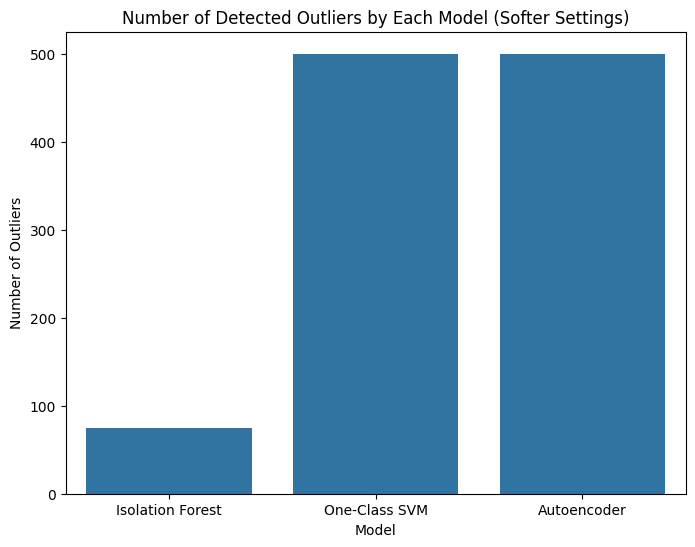

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

# ================================
# 1. Загрузка и предварительная обработка данных
# ================================

# Загружаем датасет Bank Marketing
data = fetch_openml(data_id=1461, as_frame=True).data
print("\n=== Bank Marketing Dataset ===")
print(data.head())

# Преобразование категориальных данных в числовые с помощью LabelEncoder
label_encoders = {}
for column in data.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# Заполнение пропусков в числовых столбцах (на случай наличия NaN)
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Масштабирование данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# ================================
# 2. Обучение моделей на условно корректных данных с "мягкими" настройками
# ================================

# Isolation Forest с мягкими настройками (ожидаем ~1% аномалий)
iso_forest = IsolationForest(random_state=42, contamination=0.01)
iso_forest.fit(data_scaled)

# One-Class SVM с уменьшенным nu и gamma='auto'
one_class_svm = OneClassSVM(nu=0.001, kernel="rbf", gamma="auto")
one_class_svm.fit(data_scaled)

# Обучение Autoencoder (нейросеть, обучаемая на реконструкцию входных данных)
input_dim = data_scaled.shape[1]
autoencoder = tf.keras.Sequential([
    tf.keras.Input(shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(input_dim)  # Выходной слой имеет размерность входных данных
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_scaled, data_scaled, epochs=50, batch_size=64, verbose=0)

# Вычисляем ошибки восстановления для обучающих данных и определяем порог по 99.9-му процентилю
reconstructed = autoencoder.predict(data_scaled)
mse = np.mean(np.power(data_scaled - reconstructed, 2), axis=1)
threshold = np.percentile(mse, 99.9)
print(f"\nAutoencoder threshold (99.9-й процентиль mse): {threshold:.4f}")

# ================================
# 3. Функция для безопасного преобразования категориальных признаков
# ================================
def safe_transform_label(le, series):
    """
    Преобразует серию значений с помощью обученного LabelEncoder.
    Если значение отсутствует в le.classes_, возвращается -1.
    """
    return series.astype(str).apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# ================================
# 4. Функция для инференса на новых данных
# ================================
def validate_new_data(new_data, scaler, iso_forest, one_class_svm, autoencoder, threshold):
    """
    Проверка новых данных:
      - Применяются те же преобразования (кодирование категориальных признаков, заполнение пропусков, масштабирование)
      - Модели возвращают предсказания: 1 – inlier (корректные), -1 – outlier (аномалия)
    """
    new_data_processed = new_data.copy()

    # Обработка категориальных признаков
    for col, le in label_encoders.items():
        if col in new_data_processed.columns:
            new_data_processed[col] = safe_transform_label(le, new_data_processed[col])

    # Заполнение пропусков для числовых столбцов
    new_data_processed[numeric_columns] = new_data_processed[numeric_columns].fillna(
        data[numeric_columns].median())

    # Масштабирование
    new_data_scaled = scaler.transform(new_data_processed)

    # Предсказание моделей
    pred_iso = iso_forest.predict(new_data_scaled)
    pred_svm = one_class_svm.predict(new_data_scaled)

    # Для автоэнкодера: вычисляем mse и сравниваем с порогом
    reconstructed_new = autoencoder.predict(new_data_scaled)
    mse_new = np.mean(np.power(new_data_scaled - reconstructed_new, 2), axis=1)
    pred_auto = np.where(mse_new > threshold, -1, 1)

    return {
        "Isolation Forest": pred_iso,
        "One-Class SVM": pred_svm,
        "Autoencoder": pred_auto
    }

# ================================
# 5. Симуляция новых данных и анализ
# ================================
# Для демонстрации возьмем случайную выборку из обучающих данных как "новые данные"
np.random.seed(42)
sample_indices = np.random.choice(data.shape[0], size=500, replace=False)
new_data = data.iloc[sample_indices].copy()

# Для имитации аномальных данных добавим шум к 10% выборки
num_anomalies = int(0.1 * new_data.shape[0])
anomaly_indices = np.random.choice(new_data.index, size=num_anomalies, replace=False)
new_data.loc[anomaly_indices, numeric_columns] = new_data.loc[anomaly_indices, numeric_columns] * 3

# Для демонстрации безопасного преобразования, добавим новое категориальное значение.
# Приводим столбец к строковому типу перед заменой.
if 'V2' in new_data.columns:
    new_data['V2'] = new_data['V2'].astype(str)
    new_data.loc[new_data.index[0], 'V2'] = 'new_value'

# Применяем функцию для проверки новых данных
results = validate_new_data(new_data, scaler, iso_forest, one_class_svm, autoencoder, threshold)

# Выводим результаты
for model_name, preds in results.items():
    num_inliers = np.sum(preds == 1)
    num_outliers = np.sum(preds == -1)
    print(f"\n=== Results for {model_name} ===")
    print(f"Number of valid (inlier) points: {num_inliers}")
    print(f"Number of outliers: {num_outliers}")

# ================================
# 6. Визуализация результатов
# ================================
outliers_count = {model: np.sum(preds == -1) for model, preds in results.items()}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(outliers_count.keys()), y=list(outliers_count.values()))
plt.title('Number of Detected Outliers by Each Model (Softer Settings)')
plt.xlabel('Model')
plt.ylabel('Number of Outliers')
plt.show()
